# Super Duper Concurso 9000
##  Josué Soto

In [1]:
import fastai.basics as fai
import torch
import fastai.vision as fv
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import gc
import matplotlib.pyplot as plt

import torchvision as tv

import numpy as np
from functools import partial

In [2]:
def load_src(folder):
    return (fv.ImageList
              .from_folder(folder)
              .split_by_folder()
              .label_from_folder())    

def load_data(src, img_size, batch_size, fine_tuning = False):
    tfms = list(fv.get_transforms())
    if fine_tuning: tfms[0] = tfms[1]
    return (src.transform(tfms,size=img_size)
               .databunch(bs=batch_size))

In [3]:
path = Path('imagenette')

In [4]:
src = load_src(path)

In [5]:
src.c

20

In [6]:
def num_params(model):
    total=0
    for p in model.parameters():
        num=1
        for s in list(p.size()):
            num *= s
        total += num
    return total

In [7]:
def identity(x):
    return x

In [8]:
class ResBlock(nn.Module):
    def __init__(self, nf, bottle=None, s=1, pre_activation=True, g=1):
        super().__init__()
        
        if bottle == None: bottle = nf
        
        self.act = nn.ReLU(inplace=True) if pre_activation else identity
        self.pre_bn = nn.BatchNorm2d(nf)
        
        BN = nn.BatchNorm2d(nf)
        nn.init.constant_(BN.weight, 0.)
        
        k = 3 if s == 1 else 4
        
        self.residual = nn.Sequential(nn.Conv2d(nf,bottle,kernel_size=1,stride=1,padding=0),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(bottle),
                                      nn.Conv2d(bottle,nf,kernel_size=k,stride=s,padding=1,groups=g,bias=False),
                                      BN)
        self.pool = identity if s==1 else nn.AvgPool2d(2)
        
    def forward(self, x):
        y = self.pre_bn(self.act(x))
        return self.pool(y) + self.residual(y)

In [47]:
model = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3,32,kernel_size=4,padding=1,stride=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    ResBlock(32),
    nn.Conv2d(32,64,kernel_size=4,padding=1,stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    ResBlock(64),
    nn.Conv2d(64,128,kernel_size=4,padding=1,stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    ResBlock(128),
    nn.Conv2d(128,256,kernel_size=4,padding=1,stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    ResBlock(256),
    nn.Conv2d(256,512,kernel_size=4,padding=1,stride=2),
    nn.AdaptiveAvgPool2d(1),
    fv.Flatten(),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512,src.c)
)

In [48]:
num_params(model)

3673818

In [49]:
data = load_data(src, img_size=224, batch_size=64)

In [50]:
from xranger import XRanger

In [51]:
opt = partial(XRanger, betas=(0.93,0.99))

In [52]:
learn = fv.Learner(data,model,wd=0.0,
                   opt_func=opt,
                   true_wd=False,bn_wd=False,
                   metrics=[fv.accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


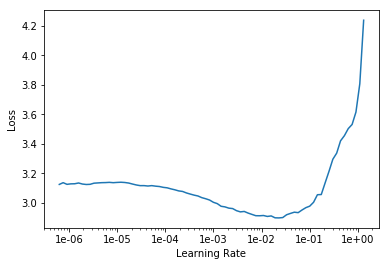

In [53]:
learn.lr_find(); learn.recorder.plot()

In [54]:
learn.fit_one_cycle(20,5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.421359,2.304898,0.293000,01:46
1,2.102030,1.896405,0.404000,01:45
2,1.849516,1.653121,0.468000,01:46
3,1.673791,1.471106,0.527000,01:45
4,1.522223,1.309242,0.594000,01:46
5,1.372978,1.197508,0.626000,01:45
6,1.224932,1.031522,0.679000,01:45
7,1.125244,0.962198,0.684000,01:44
8,0.977616,0.891605,0.699000,01:45
9,0.928170,0.851917,0.725000,01:44


In [56]:
img = torch.rand(64,3,224,224).cuda()

In [57]:
%%timeit
torch.cuda.synchronize()
model(img)
torch.cuda.synchronize()

12.1 ms ± 1.82 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
r34 = fv.models.resnet34(pretrained=False).cuda()

In [59]:
%%timeit
torch.cuda.synchronize()
r34(img)
torch.cuda.synchronize()

50.2 ms ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
num_params(r34)

21797672